# Crime Classification – CS 9548 Project
**Goal:** Exploring Machine Learning Techniques for Image Classification

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Download and Extract Dataset

In [2]:
!pip install kagglehub

import kagglehub
path = kagglehub.dataset_download("odins0n/ucf-crime-dataset")

print("Path to dataset files:", path)

100%|██████████| 11.0G/11.0G [08:22<00:00, 23.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/odins0n/ucf-crime-dataset/versions/1


## Create DataFrame of Images

In [3]:
import pathlib
import pandas as pd

# Get directories of train and test datasets
data_dir = pathlib.Path(path)
train_dir = data_dir / "Train"
test_dir = data_dir / "Test"

print("Data dir:", data_dir)
print(train_dir)
print(test_dir)

# Function to build dataframe
def build_image_df(root_dir):
    root_dir = pathlib.Path(root_dir)
    image_paths = list(root_dir.glob("*/*.png"))

    rows = []

    for p in image_paths:
        label = p.parent.name
        rows.append({"image": str(p), "label": label})

    return pd.DataFrame(rows)


# Build train and test dataframes
train_df = build_image_df(train_dir)
test_df = build_image_df(test_dir)

print(train_df['label'].value_counts())
print(test_df['label'].value_counts())

Data dir: /root/.cache/kagglehub/datasets/odins0n/ucf-crime-dataset/versions/1
/root/.cache/kagglehub/datasets/odins0n/ucf-crime-dataset/versions/1/Train
/root/.cache/kagglehub/datasets/odins0n/ucf-crime-dataset/versions/1/Test
label
NormalVideos     947768
Stealing          44802
Robbery           41493
Burglary          39504
Arrest            26397
Shoplifting       24835
Fighting          24684
Arson             24421
RoadAccidents     23486
Abuse             19076
Explosion         18753
Vandalism         13626
Assault           10360
Shooting           7140
Name: count, dtype: int64
label
NormalVideos     64952
Burglary          7657
Shooting          7630
Shoplifting       7623
Explosion         6510
Arrest            3365
Arson             2793
RoadAccidents     2663
Assault           2657
Stealing          1984
Fighting          1231
Vandalism         1111
Robbery            835
Abuse              297
Name: count, dtype: int64


## Encode Label as Integer

In [4]:
from sklearn.preprocessing import LabelEncoder

# Create and fit label encoder on training labels
le = LabelEncoder()
train_df['label_idx'] = le.fit_transform(train_df['label'])

# Apply the same encoding to test labels
test_df['label_idx']  = le.transform(test_df['label'])

# Number of classes and mapping
num_classes = len(le.classes_)
print("Number of classes:", num_classes)
print("Class name vs label_idx:")
for index, cls in enumerate(le.classes_):
    print(index, cls)

Number of classes: 14
Class name vs label_idx:
0 Abuse
1 Arrest
2 Arson
3 Assault
4 Burglary
5 Explosion
6 Fighting
7 NormalVideos
8 RoadAccidents
9 Robbery
10 Shooting
11 Shoplifting
12 Stealing
13 Vandalism


We can see that the dataset has a large class imbalance. To mitigate this, we can do some under/oversampling, as well as data augmentation.

## Add Video Column ID

In [5]:
def extract_video_id(path_str):
    stem = pathlib.Path(path_str).stem

    # split off the last chunk
    video_id = stem.rsplit("_", 1)[0]

    return video_id

train_df['video_id'] = train_df['image'].apply(extract_video_id)
test_df['video_id']  = test_df['image'].apply(extract_video_id)

## Split Train Into Train and Val

In [6]:
from sklearn.model_selection import train_test_split
import numpy as np

unique_videos = train_df['video_id'].unique()

video_labels = (
    train_df.groupby('video_id')['label_idx'].agg(lambda x: np.bincount(x).argmax()).reindex(unique_videos)
)

# 80% train 20% val
train_vids, val_vids = train_test_split(
    unique_videos,
    test_size=0.20,
    random_state=42,
    stratify=video_labels
)

train_df_raw = train_df[train_df['video_id'].isin(train_vids)].reset_index(drop=True)
val_df = train_df[train_df['video_id'].isin(val_vids)].reset_index(drop=True)

print("\nNum train videos:", len(train_vids))
print("Num val videos:", len(val_vids))
print("Train frames:", len(train_df_raw))
print("Val frames:", len(val_df))
print("Test frames:", len(test_df))


Num train videos: 1288
Num val videos: 322
Train frames: 1015239
Val frames: 251106
Test frames: 111308


# No Over/undersampling

In [7]:
train_df_used = train_df_raw

# Compute class counts (sorted by label index)
class_counts = train_df_used['label_idx'].value_counts().sort_index().values
num_classes = len(class_counts)

# Inverse-frequency style weights
# weight_c = total_samples / (num_classes * count_c)

class_weights = class_counts.sum() / (num_classes * class_counts)
print("Class weights:", class_weights)



Class weights: [ 4.56656621  3.03291809  7.87629754  8.33912965  2.10267546  4.04942324
  3.67398275  0.09532025  3.7558044   2.19104666 11.95270668  3.20886196
  2.25621703  6.34611634]


In [8]:
print(train_df_used['label'].value_counts())

label
NormalVideos     760773
Burglary          34488
Robbery           33097
Stealing          32141
Arrest            23910
Shoplifting       22599
Fighting          19738
RoadAccidents     19308
Explosion         17908
Abuse             15880
Vandalism         11427
Arson              9207
Assault            8696
Shooting           6067
Name: count, dtype: int64


## Set up PyTorch

In [9]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

# Set constants for PyTorch
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

## Data Augmentation

In [10]:
# Data augmentation to training dataset
train_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(contrast=0.1, brightness=0.1),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])

# Simple transforms to val/test dataset
eval_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])

## Create Pipeline For PyTorch

In [11]:
class CrimeDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row['image']
        label = int(row['label_idx'])

        # Load the image
        image = Image.open(img_path).convert("RGB")

        # Transform if needed (might not need for val/test)
        if self.transform:
            image = self.transform(image)

        return image, label

## Create DataLoaders

In [12]:
# First convert to CrimeDataset classes
train_dataset = CrimeDataset(train_df_used, train_transform)
val_dataset = CrimeDataset(val_df, eval_transform)
test_dataset = CrimeDataset(test_df, eval_transform)

# Transform to DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

In [13]:
images, labels = next(iter(train_loader))
print("\nSample batch shapes -> images:", images.shape, "labels:", labels.shape)


Sample batch shapes -> images: torch.Size([32, 3, 224, 224]) labels: torch.Size([32])


## Create ResNet18 Model

In [14]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Freeze all layers initially (warmup)
for param in resnet.parameters():
    param.requires_grad = False

# Replace final fully-connected layer
num_features = resnet.fc.in_features
resnet.fc = nn.Linear(num_features, num_classes)

model = resnet.to(device)

# Move class weights to same device
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

# Class-weighted loss
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

# Add L2 regularization via weight_decay
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

Using device: cuda
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 196MB/s]


## Training and Testing

In [15]:
import torch.optim as optim

def train(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

In [16]:
def test(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.inference_mode():
        for images, labels in loader:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

In [17]:
WARMUP_EPOCHS = 3

for epoch in range(1, WARMUP_EPOCHS + 1):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = test(model, val_loader, criterion, device)

    print(
        f"[Warmup] Epoch {epoch}/{WARMUP_EPOCHS} | "
        f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
        f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
    )

[Warmup] Epoch 1/3 | Train Loss: 1.1553, Train Acc: 0.6457 | Val Loss: 3.0057, Val Acc: 0.1724
[Warmup] Epoch 2/3 | Train Loss: 1.0238, Train Acc: 0.6713 | Val Loss: 3.0717, Val Acc: 0.1586
[Warmup] Epoch 3/3 | Train Loss: 1.0005, Train Acc: 0.6745 | Val Loss: 2.7313, Val Acc: 0.2294


In [18]:
for param in model.parameters():
    param.requires_grad = True

In [19]:
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

EPOCHS = 5

for epoch in range(1, EPOCHS + 1):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = test(model, val_loader, criterion, device)

    print(
        f"Epoch {epoch}/{EPOCHS} | "
        f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
        f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
    )

Epoch 1/5 | Train Loss: 0.1455, Train Acc: 0.9459 | Val Loss: 2.5274, Val Acc: 0.6840
Epoch 2/5 | Train Loss: 0.0481, Train Acc: 0.9793 | Val Loss: 2.4954, Val Acc: 0.6476
Epoch 3/5 | Train Loss: 0.0367, Train Acc: 0.9840 | Val Loss: 2.0067, Val Acc: 0.6636
Epoch 4/5 | Train Loss: 0.0320, Train Acc: 0.9864 | Val Loss: 2.5220, Val Acc: 0.6625
Epoch 5/5 | Train Loss: 0.0285, Train Acc: 0.9883 | Val Loss: 1.9934, Val Acc: 0.6317


In [20]:
test_loss, test_acc = test(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")


Test Loss: 3.7371, Test Acc: 0.4667


## Get predictions on test set

In [22]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

model.eval()

all_preds = []
all_labels = []

with torch.inference_mode():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Flatten lists into arrays
y_pred = np.concatenate(all_preds)
y_true = np.concatenate(all_labels)

print("y_true shape:", y_true.shape)
print("y_pred shape:", y_pred.shape)

y_true shape: (111308,)
y_pred shape: (111308,)


In [23]:
report = classification_report(
    y_true,
    y_pred,
    target_names=le.classes_,
    digits=4
)

print("Classification Report:\n")
print(report)

Classification Report:

               precision    recall  f1-score   support

        Abuse     0.0181    0.0842    0.0297       297
       Arrest     0.0840    0.0788    0.0813      3365
        Arson     0.1272    0.1998    0.1554      2793
      Assault     0.0000    0.0000    0.0000      2657
     Burglary     0.2840    0.2933    0.2886      7657
    Explosion     0.1123    0.0266    0.0430      6510
     Fighting     0.0522    0.0211    0.0301      1231
 NormalVideos     0.8168    0.7112    0.7604     64952
RoadAccidents     0.1254    0.4348    0.1946      2663
      Robbery     0.0242    0.2838    0.0445       835
     Shooting     0.0571    0.0106    0.0179      7630
  Shoplifting     0.3342    0.0534    0.0921      7623
     Stealing     0.0693    0.2792    0.1111      1984
    Vandalism     0.0066    0.0225    0.0102      1111

     accuracy                         0.4667    111308
    macro avg     0.1508    0.1785    0.1328    111308
 weighted avg     0.5404    0.4667    0

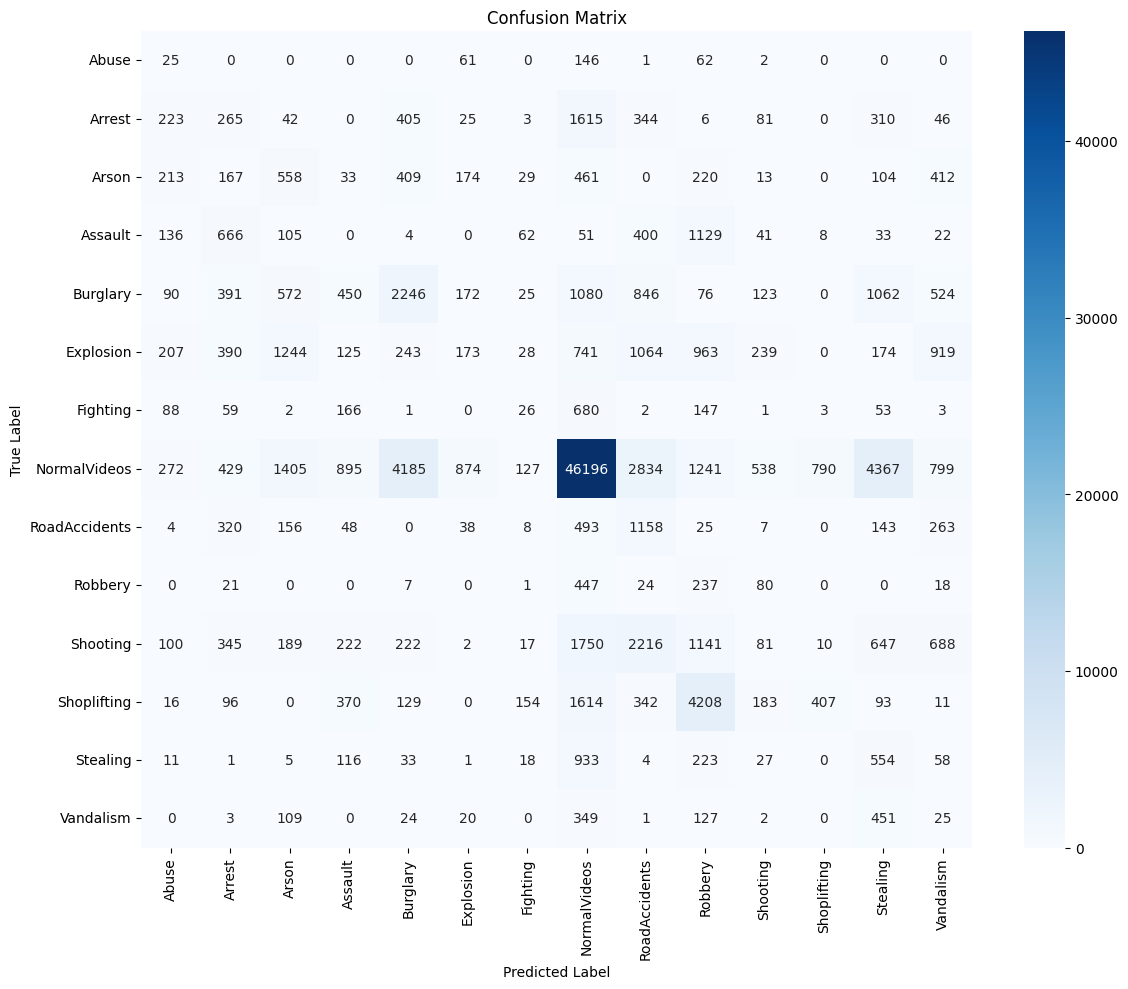

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=le.classes_,
            yticklabels=le.classes_)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [29]:
import pandas as pd
import numpy as np

cm_df = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)

# Zero out the diagonal (correct predictions)
np.fill_diagonal(cm_df.values, 0)

# Find the top confusions
confusion_pairs = (
    cm_df.stack()
    .reset_index()
    .rename(columns={"level_0": "True", "level_1": "Predicted", 0: "Count"})
    .sort_values(by="Count", ascending=False)
)

print("Top 10 Most Confused Class Pairs:")
print(confusion_pairs.head(10))

Top 10 Most Confused Class Pairs:
             True      Predicted  Count
110  NormalVideos       Stealing   4367
163   Shoplifting        Robbery   4208
102  NormalVideos       Burglary   4185
106  NormalVideos  RoadAccidents   2834
148      Shooting  RoadAccidents   2216
147      Shooting   NormalVideos   1750
21         Arrest   NormalVideos   1615
161   Shoplifting   NormalVideos   1614
100  NormalVideos          Arson   1405
72      Explosion          Arson   1244


In [30]:
from sklearn.metrics import classification_report

report_dict = classification_report(
    y_true,
    y_pred,
    target_names=le.classes_,
    output_dict=True
)

recall_df = pd.DataFrame(report_dict).T[['recall', 'support']]

# Remove overall rows
recall_df = recall_df.drop(index=['accuracy', 'macro avg', 'weighted avg'])

# Sort by worst recall
recall_df = recall_df.sort_values(by='recall')

print("Classes With Worst Recall (Missed Most Often):")
print(recall_df.head(5))

Classes With Worst Recall (Missed Most Often):
             recall  support
Assault    0.000000   2657.0
Shooting   0.010616   7630.0
Fighting   0.021121   1231.0
Vandalism  0.022502   1111.0
Explosion  0.026575   6510.0


In [31]:
precision_df = pd.DataFrame(report_dict).T[['precision', 'support']]
precision_df = precision_df.drop(index=['accuracy', 'macro avg', 'weighted avg'])
precision_df = precision_df.sort_values(by='precision')

print("Classes With Worst Precision (Most False Positives):")
print(precision_df.head(5))

Classes With Worst Precision (Most False Positives):
           precision  support
Assault     0.000000   2657.0
Vandalism   0.006600   1111.0
Abuse       0.018051    297.0
Robbery     0.024171    835.0
Fighting    0.052209   1231.0


In [32]:
print(confusion_pairs.head(10))
print(recall_df.head(5))

             True      Predicted  Count
110  NormalVideos       Stealing   4367
163   Shoplifting        Robbery   4208
102  NormalVideos       Burglary   4185
106  NormalVideos  RoadAccidents   2834
148      Shooting  RoadAccidents   2216
147      Shooting   NormalVideos   1750
21         Arrest   NormalVideos   1615
161   Shoplifting   NormalVideos   1614
100  NormalVideos          Arson   1405
72      Explosion          Arson   1244
             recall  support
Assault    0.000000   2657.0
Shooting   0.010616   7630.0
Fighting   0.021121   1231.0
Vandalism  0.022502   1111.0
Explosion  0.026575   6510.0


In [38]:
from sklearn.metrics import balanced_accuracy_score

bal_acc = balanced_accuracy_score(y_true, y_pred)
print("Balanced Accuracy:", bal_acc)

Balanced Accuracy: 0.17852788236649017


In [39]:
import torch
import numpy as np

top3_correct = 0
total = 0

with torch.inference_mode():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, top3 = torch.topk(outputs, k=3, dim=1)

        # Check if true label is in top-3 predictions
        match = (top3 == labels.unsqueeze(1)).any(dim=1)
        top3_correct += match.sum().item()
        total += labels.size(0)

top3_acc = top3_correct / total
print("Top-3 Accuracy:", top3_acc)


Top-3 Accuracy: 0.6931038200309052


In [40]:
torch.save(model.state_dict(), "resnet18_crime_classifier.pth")

# Also save label encoder classes for decoding predictions later
np.save("label_classes.npy", le.classes_)

In [41]:
!ls /content

drive  label_classes.npy  resnet18_crime_classifier.pth  sample_data


In [42]:
torch.save(
    model.state_dict(),
    "/content/drive/MyDrive/resnet18_crime_classifier.pth"
)

np.save(
    "/content/drive/MyDrive/label_classes.npy",
    le.classes_
)

print("Model and labels saved to Google Drive!")

Model and labels saved to Google Drive!
